In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import json
from tqdm import tqdm
import copy
import os
import pandas as pd
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForCausalLM

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

# To ignore warnings
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [44]:
class MLPProbe(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.linear1 = nn.Linear(d, 100)
        self.linear2 = nn.Linear(100, 1)

    def forward(self, x):
        h = F.relu(self.linear1(x))
        o = self.linear2(h)
        return torch.sigmoid(o)

class CCS(object):
    def __init__(self, x0, x1, nepochs=1000, ntries=10, lr=1e-3, batch_size=-1, 
                 verbose=False, device="mps", linear=True, weight_decay=0.01, var_normalize=False):
        # data
        self.var_normalize = var_normalize
        self.x0 = self.normalize(x0)
        self.x1 = self.normalize(x1)
        self.d = self.x0.shape[-1]

        # training
        self.nepochs = nepochs
        self.ntries = ntries
        self.lr = lr
        self.verbose = verbose
        self.device = device
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        
        # probe
        self.linear = linear
        self.initialize_probe()
        self.best_probe = copy.deepcopy(self.probe)

        
    def initialize_probe(self):
        if self.linear:
            self.probe = nn.Sequential(nn.Linear(self.d, 1), nn.Sigmoid())
        else:
            self.probe = MLPProbe(self.d)
        self.probe.to(self.device)    


    def normalize(self, x):
        """
        Mean-normalizes the data x (of shape (n, d))
        If self.var_normalize, also divides by the standard deviation
        """
        normalized_x = x - x.mean(axis=0, keepdims=True)
        if self.var_normalize:
            normalized_x /= normalized_x.std(axis=0, keepdims=True)

        return normalized_x

        
    def get_tensor_data(self):
        """
        Returns x0, x1 as appropriate tensors (rather than np arrays)
        """
        x0 = torch.tensor(self.x0, dtype=torch.float, requires_grad=False, device=self.device)
        x1 = torch.tensor(self.x1, dtype=torch.float, requires_grad=False, device=self.device)
        return x0, x1
    

    def get_loss(self, p0, p1):
        """
        Returns the CCS loss for two probabilities each of shape (n,1) or (n,)
        """
        informative_loss = (torch.min(p0, p1)**2).mean(0)
        consistent_loss = ((p0 - (1-p1))**2).mean(0)
        return informative_loss + consistent_loss


    def get_acc(self, x0_test, x1_test, y_test):
        """
        Computes accuracy for the current parameters on the given test inputs
        """
        x0 = torch.tensor(self.normalize(x0_test), dtype=torch.float, requires_grad=False, device=self.device)
        x1 = torch.tensor(self.normalize(x1_test), dtype=torch.float, requires_grad=False, device=self.device)
        with torch.no_grad():
            p0, p1 = self.best_probe(x0), self.best_probe(x1)
        avg_confidence = 0.5*(p0 + (1-p1))
        predictions = (avg_confidence.detach().cpu().numpy() < 0.5).astype(int)[:, 0]
        acc = (predictions == y_test).mean()
        acc = max(acc, 1 - acc)

        return acc
    
        
    def train(self):
        """
        Does a single training run of nepochs epochs
        """
        x0, x1 = self.get_tensor_data()
        permutation = torch.randperm(len(x0))
        x0, x1 = x0[permutation], x1[permutation]
        
        # set up optimizer
        optimizer = torch.optim.AdamW(self.probe.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        
        batch_size = len(x0) if self.batch_size == -1 else self.batch_size
        nbatches = len(x0) // batch_size

        # Start training (full batch)
        for epoch in range(self.nepochs):
            for j in range(nbatches):
                x0_batch = x0[j*batch_size:(j+1)*batch_size]
                x1_batch = x1[j*batch_size:(j+1)*batch_size]
            
                # probe
                p0, p1 = self.probe(x0_batch), self.probe(x1_batch)
                # get the corresponding loss
                loss = self.get_loss(p0, p1)

                # update the parameters
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return loss.detach().cpu().item()
    
    def repeated_train(self):
        best_loss = np.inf
        for train_num in range(self.ntries):
            self.initialize_probe()
            loss = self.train()
            if loss < best_loss:
                self.best_probe = copy.deepcopy(self.probe)
                best_loss = loss

        return best_loss
    
    def predict(self, pos, neg):
        x0 = torch.tensor(self.normalize(pos), dtype=torch.float, requires_grad=False, device=self.device)
        x1 = torch.tensor(self.normalize(neg), dtype=torch.float, requires_grad=False, device=self.device)
        with torch.no_grad():
            p0, p1 = self.best_probe(x0), self.best_probe(x1)
        avg_confidence = 0.5*(p0 + (1-p1))
        predictions = (avg_confidence.detach().cpu().numpy() < 0.5).astype(int)[:, 0]
        return predictions

In [45]:
def load_data(trial_name):
    """
    Loads all the layers of a given trial
    Output shape:
        hs: (N x layers x dim)
        y: (N)
    """
    path = os.path.join(os.getcwd(), "saved")
    root = os.path.join(path, trial_name)
    neg_hs_layers = np.load(os.path.join(root, "fem-hs.npy"))
    pos_hs_layers = np.load(os.path.join(root, "male-hs.npy"))
    y = np.load(os.path.join(root, "y.npy"))
    return neg_hs_layers, pos_hs_layers, y

In [46]:
def process_data_layer(layer, neg_hs_layers, pos_hs_layers, y, verbose=False):
    """
    Takes in total data and processes a single layer.
    Randomly permutes it and splits into train and test sets.
    Output shape:
        hs: (N x dim)
        y: (N)
    """
    # Get the hidden states for the given layer
    neg_hs = neg_hs_layers[:,layer,:]
    pos_hs = pos_hs_layers[:,layer,:]

    # Randomly permute
    n = len(y)
    p = np.random.permutation(n)
    neg_hs = neg_hs[p]
    pos_hs = pos_hs[p]
    y = y[p]

    # Train test split
    s = int(n*0.6)
    neg_hs_train, neg_hs_test = neg_hs[:s], neg_hs[s:]
    pos_hs_train, pos_hs_test = pos_hs[:s], pos_hs[s:]
    y_train, y_test = y[:s], y[s:]
    
    if verbose:
        print(neg_hs.shape, pos_hs.shape, y.shape)
        print(y_test.sum()/len(y_test))

    return (neg_hs_train, pos_hs_train, y_train), (neg_hs_test, pos_hs_test, y_test)

In [47]:
@ignore_warnings(category=ConvergenceWarning)
def train_lr(train_data, test_data, verbose=False):
    """
    Trains and evaluates logistic regression on difference of pos and neg hs
    Input: tuples of (neg_hs, pos_hs, y)
    """
    neg_hs_train, pos_hs_train, y_train = train_data
    neg_hs_test, pos_hs_test, y_test = test_data

    # for simplicity we can just take the difference between positive and negative hidden states
    # (concatenating also works fine)
    x_train = neg_hs_train - pos_hs_train
    x_test = neg_hs_test - pos_hs_test

    lr = LogisticRegression(class_weight="balanced")
    lr.fit(x_train, y_train)
    
    lr_pred = lr.predict(x_test)
    f1 = f1_score(y_test, lr_pred)
    acc = accuracy_score(y_test, lr_pred)
    if verbose:
        print(f"lr f1 score: {f1}")
        print(f"lr accuracy: {acc}")

    return lr, f1

In [48]:
def train_ccs(train_data, test_data, verbose=False):
    """
    Trains and evaluates ccs
    Input: tuples of (neg_hs, pos_hs, y)
    """
    neg_hs_train, pos_hs_train, y_train = train_data
    neg_hs_test, pos_hs_test, y_test = test_data

    ccs = CCS(neg_hs_train, pos_hs_train, batch_size=-1, var_normalize=True, nepochs=100)
    loss = ccs.repeated_train()
    if verbose:
        print(f"ccs loss: {loss}")

    # Normalize our test vectors
    y_pred = ccs.predict(ccs.normalize(neg_hs_test), ccs.normalize(pos_hs_test))
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    if verbose:
        print(f"f1 score: {f1}")
        print(f"accuracy: {acc}")
        print(confusion_matrix(y_test, y_pred))

    return ccs, f1

In [49]:
def plot_f1(ccs_f1s, lr_f1s):
    # Scatter points
    plt.scatter(range(len(ccs_f1s)), ccs_f1s, label="ccs")
    plt.scatter(range(len(lr_f1s)), lr_f1s, label="lr")
    # Horizontal line at 0.5
    plt.axhline(y=0.5, color="r", linestyle="-")
    # Set range
    plt.ylim(0, 1)
    plt.title("F1 Score by Layer")
    plt.xlabel("Layer")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.show()

In [50]:
def train_layers(trial_name):
    neg_hs_layers, pos_hs_layers, y = load_data(trial_name)

    ccs_f1s = []
    lr_f1s = []
    for layer in tqdm(range(neg_hs_layers.shape[1])):
        train_data, test_data = process_data_layer(layer, neg_hs_layers, pos_hs_layers, y)
        ccs, ccs_f1 = train_ccs(train_data, test_data)
        l1, lr_f1 = train_lr(train_data, test_data)

        ccs_f1s.append(ccs_f1)
        lr_f1s.append(lr_f1)
    return ccs_f1s, lr_f1s

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [01:05<00:00,  5.04s/it]


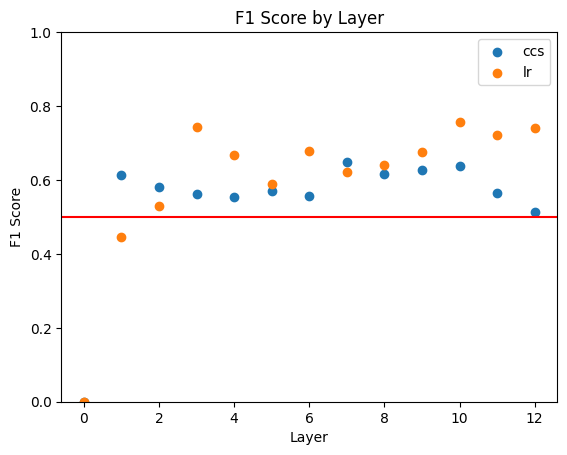

100%|██████████| 25/25 [02:07<00:00,  5.09s/it]


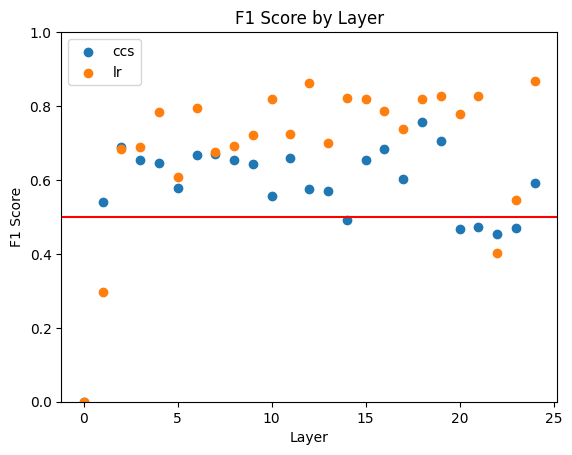

In [51]:
np.random.seed(42)
# trial_names = ["gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl"]
trial_names = ["roberta-base", "roberta-large"]
for trial_name in trial_names:
    ccs_f1s, lr_f1s = train_layers(trial_name)
    plot_f1(ccs_f1s, lr_f1s)
    results_dir = f"results/{trial_name}"
    if not os.path.exists(os.path.join(os.getcwd(), results_dir)):
        os.mkdir(os.path.join(os.getcwd(), results_dir))
    np.save(os.path.join(os.getcwd(), f"results/{trial_name}/ccs_f1s.npy"), np.array(ccs_f1s))
    np.save(os.path.join(os.getcwd(), f"results/{trial_name}/lr_f1s.npy"), np.array(lr_f1s))